# 3. Building Custom Recurrent Models

In the previous notebook we have looked at building custom models. We revisit this here, but this time the model is going to also be recurrent. It will be a very short tutorial, as the intricacy lies solely in the model building function. Everything else, i.e. handling the model, will be happening under the hood of AngoraPy, which automatically detects whether your model is recurrent and not, and then deals with it accordingly.

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import tensorflow as tf
import angorapy as apy

env = apy.make_env("CartPole-v1")
distribution = apy.policies.CategoricalPolicyDistribution(env)

The model we build is going to be quite similar to the previous one, however we replace the last shared feedforward layers by a shared GRU recurrent layer. AngoraPy's training algorithm requires you to make the recurrent layers both stateful and returning sequences. Additionally, you need to set the batch size. 

In [5]:
from tensorflow.keras.layers import TimeDistributed
from angorapy.utilities.util import env_extract_dims


def build_my_amazing_model(env, distribution, bs=1, sequence_length=1):
    state_dimensionality, n_actions = env_extract_dims(env)

    inputs = tf.keras.Input(batch_shape=(bs, sequence_length,) + state_dimensionality["proprioception"], name="proprioception")
    masked = tf.keras.layers.Masking(batch_input_shape=(bs, sequence_length,) + (inputs.shape[-1], ))(inputs)

    x = TimeDistributed(tf.keras.layers.Dense(8))(masked)

    x, *_ = tf.keras.layers.GRU(4,
                       stateful=True,
                       return_sequences=True,
                       return_state=True,
                       batch_size=bs,
                       name="policy_recurrent_layer")(x)

    x_policy = tf.keras.layers.Dense(8)(x)
    x_value = tf.keras.layers.Dense(8)(x)

    out_policy = distribution.build_action_head(n_actions, x_policy.shape[1:], bs)(x_policy)
    out_value = tf.keras.layers.Dense(1)(x_value)

    policy = tf.keras.Model(inputs=inputs, outputs=out_policy, name="my_policy_function")
    value = tf.keras.Model(inputs=inputs, outputs=out_value, name="my_value_function")
    joint = tf.keras.Model(inputs=inputs, outputs=[out_policy, out_value], name="my_joint_networks")

    return policy, value, joint

We wont load the model this time, so we can skip registering it. However, lets again plot the model after building the agent.

Detected 0 GPU devices.
Using [StateNormalizationTransformer, RewardNormalizationTransformer] for preprocessing.
An MPI Optimizer with 1 ranks has been created; the following ranks optimize: [0]


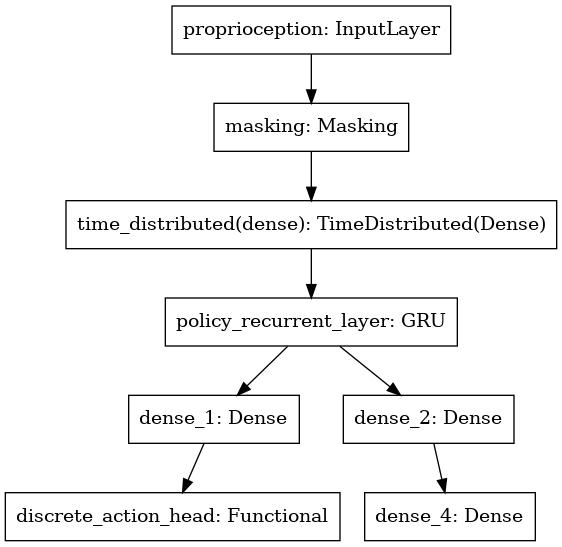

In [6]:
from tensorflow.keras.utils import plot_model

agent = apy.Agent(build_my_amazing_model, env, horizon=2048, workers=1, distribution=distribution)
plot_model(agent.joint)

Great. Now only training is left.

In [7]:
agent.drill(n=10, epochs=3, batch_size=128)
agent.save_agent_state()



Drill started using 1 processes for 1 workers of which 1 are optimizers. Worker distribution: [1].
IDs over Workers: [[0]]
IDs over Optimizers: [[0]]

The policy is recurrent and the batch size is interpreted as the number of transitions per policy update. Given the batch size of 128 this results in: 
	8 chunks per update and 16 updates per epoch
	Batch tilings of (1, 8) per process and (1, 8) in total.


Gathering cycle 0...

Gathering experience...: 100%|█████████████| 2048/2048 [00:17<00:00, 120.28it/s]


Before Training: r:    22.41; len:    22.41; n:  69; loss: [  pi  |  v     |  ent ]; eps:     0; lr: 1.00e-03; upd:      0; f:    0.000k; y.exp: 0.000; w: 0.25; times:  ; took s [unknown time left]; mem: 1.76/12|0.0/0.0;


Optimizing...: 100%|████████████████████████████| 48/48 [00:06<00:00,  7.02it/s]


Gathering cycle 1...

Gathering experience...: 100%|█████████████| 2048/2048 [00:20<00:00, 102.19it/s]


Cycle     1/10: r:    25.03; len:    25.03; n:  63; loss: [ 17.45|    8.05|  0.68]; eps:    69; lr: 1.00e-03; upd:     48; f:    2.048k; w: 0.23; times: [17.3|0.0|7.2] [71|0|29]; took 27.58s [4.1mins left]; mem: 1.78/12|0.0/0.0;


Optimizing...: 100%|████████████████████████████| 48/48 [00:06<00:00,  7.76it/s]


Gathering cycle 2...

Gathering experience...: 100%|█████████████| 2048/2048 [00:20<00:00, 101.93it/s]


Cycle     2/10: r:    34.33; len:    34.33; n:  49; loss: [ 17.06|    7.69|  0.65]; eps:   132; lr: 1.00e-03; upd:     96; f:    4.096k; w: 0.16; times: [20.2|0.0|6.4] [76|0|24]; took 26.86s [3.6mins left]; mem: 1.79/12|0.0/0.0;


Optimizing...: 100%|████████████████████████████| 48/48 [00:06<00:00,  7.64it/s]


Gathering cycle 3...

Gathering experience...: 100%|██████████████| 2048/2048 [00:21<00:00, 95.96it/s]


Cycle     3/10: r:    57.38; len:    57.38; n:  32; loss: [  0.16|    0.10|  0.66]; eps:   181; lr: 1.00e-03; upd:    144; f:    6.144k; w: 0.1; times: [20.3|0.0|6.5] [76|0|24]; took 28.22s [3.2mins left]; mem: 1.78/12|0.0/0.0;


Optimizing...: 100%|████████████████████████████| 48/48 [00:06<00:00,  7.90it/s]


Gathering cycle 4...

Gathering experience...: 100%|██████████████| 2048/2048 [00:21<00:00, 97.20it/s]


Cycle     4/10: r:    78.57; len:    78.57; n:  23; loss: [ 17.86|    8.16|  0.49]; eps:   213; lr: 1.00e-03; upd:    192; f:    8.192k; w: 0.1; times: [21.5|0.0|6.3] [77|0|23]; took 27.71s [2.8mins left]; mem: 1.78/12|0.0/0.0;


Optimizing...: 100%|████████████████████████████| 48/48 [00:06<00:00,  7.61it/s]


Gathering cycle 5...

Gathering experience...: 100%|██████████████| 2048/2048 [00:22<00:00, 92.39it/s]


Cycle     5/10: r:   116.94; len:   116.94; n:  16; loss: [  0.31|    0.02|  0.61]; eps:   236; lr: 1.00e-03; upd:    240; f:   10.240k; w: 0.07; times: [21.2|0.0|6.5] [77|0|23]; took 29.03s [2.3mins left]; mem: 1.78/12|0.0/0.0;


Optimizing...: 100%|████████████████████████████| 48/48 [00:06<00:00,  7.53it/s]


Gathering cycle 6...

Gathering experience...: 100%|██████████████| 2048/2048 [00:22<00:00, 90.43it/s]


Cycle     6/10: r:   163.27; len:   163.27; n:  11; loss: [  0.36|    0.01|  0.65]; eps:   252; lr: 1.00e-03; upd:    288; f:   12.288k; w: 0.05; times: [22.3|0.0|6.6] [77|0|23]; took 29.62s [1.9mins left]; mem: 1.78/12|0.0/0.0;


Optimizing...: 100%|████████████████████████████| 48/48 [00:06<00:00,  7.72it/s]


Gathering cycle 7...

Gathering experience...: 100%|██████████████| 2048/2048 [00:23<00:00, 88.42it/s]


Cycle     7/10: r:   194.80; len:   194.80; n:  10; loss: [  0.36|    0.01|  0.64]; eps:   263; lr: 1.00e-03; upd:    336; f:   14.336k; w: 0.03; times: [22.8|0.0|6.4] [78|0|22]; took 29.96s [1.4mins left]; mem: 1.78/12|0.0/0.0;


Optimizing...: 100%|████████████████████████████| 48/48 [00:06<00:00,  7.65it/s]


Gathering cycle 8...

Gathering experience...: 100%|██████████████| 2048/2048 [00:22<00:00, 89.97it/s]


Cycle     8/10: r:   236.38; len:   236.38; n:   8; loss: [  1.44|    0.13|  0.47]; eps:   273; lr: 1.00e-03; upd:    384; f:   16.384k; w: 0.03; times: [23.3|0.0|6.5] [78|0|22]; took 29.63s [1.0mins left]; mem: 1.78/12|0.0/0.0;


Optimizing...: 100%|████████████████████████████| 48/48 [00:06<00:00,  7.59it/s]


Gathering cycle 9...

Gathering experience...: 100%|██████████████| 2048/2048 [00:22<00:00, 92.33it/s]


Cycle     9/10: r:   236.25; len:   236.25; n:   8; loss: [  0.15|    0.00|  0.61]; eps:   281; lr: 1.00e-03; upd:    432; f:   18.432k; w: 0.03; times: [22.9|0.0|6.6] [78|0|22]; took 29.14s [0.5mins left]; mem: 1.78/12|0.0/0.0;


Optimizing...: 100%|████████████████████████████| 48/48 [00:05<00:00,  8.11it/s]


Finalizing...Drill finished after 282.27serialization.


You might have noticed that the drill function informed you about some details on the training that it did not include previously, because the model is recurrent. Because AngoraPy operates on temporal data, and specifically temporal chunks (as opposed to full sequences), it needs to convert the batch size you provide it with (which is the number of transitions included in every batch) into the number of chunks it processes per update. If we would distribute the training, it would additionally have to allocate chunks to the processes. 

Lets evaluate again. Most likely, training ended at a lower performance than our feedforward model. Thats because training recurrent policies is generally requiring more data, and for the given task we also do not need a memory. The state dynamics are already explicitly included as variables.

In [8]:
evaluation_results = agent.evaluate(1, act_confidently=True)[0]
print(f"Mean performance after training: {np.mean(evaluation_results.episode_rewards)}")

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]

Mean performance after training: 255.0


Thats it for model building. Next, we will learn how to load and inspect agents.